[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2021-01-04 00:00:00
2021-01-04 00:00:00
2021-01-04 00:00:00


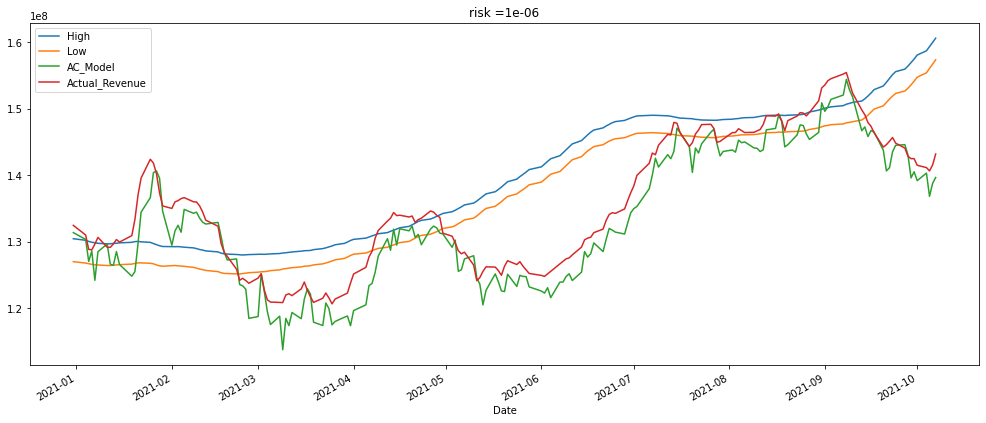

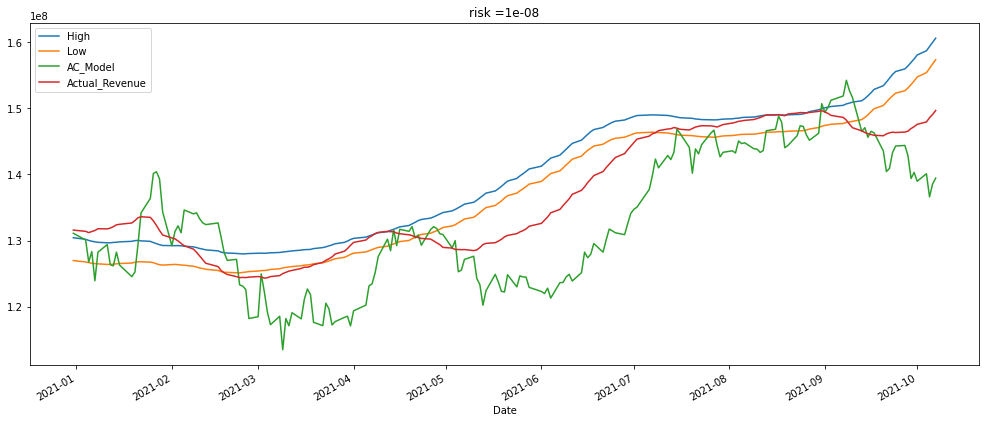

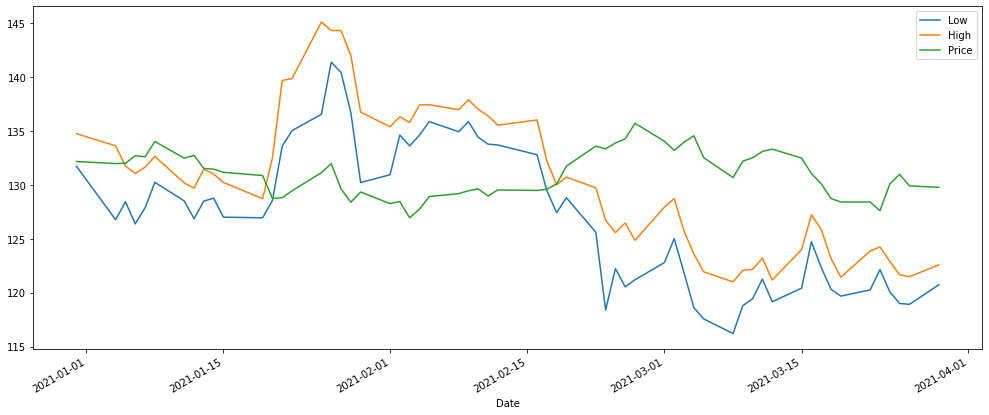

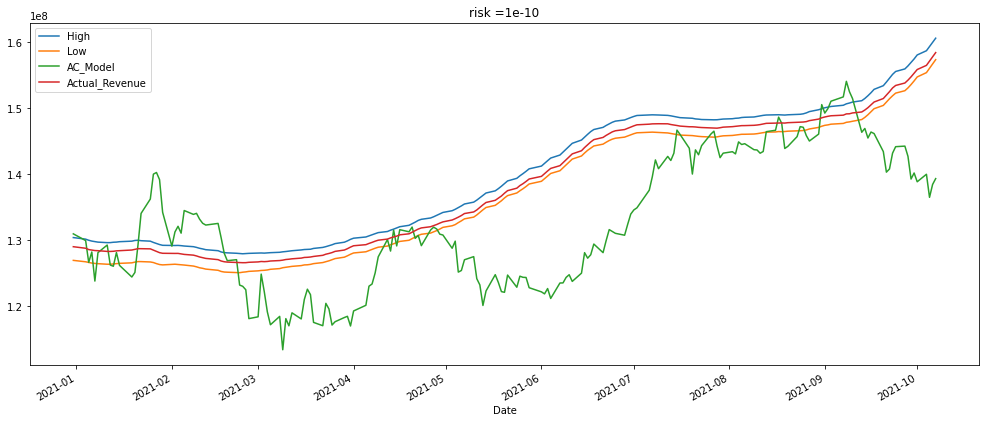

In [2]:
import pandas as pd
import FinanceDataReader as fdr
import copy
import syntheticChrissAlmgren2 as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta



class AC_model():
    def __init__(self, TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list):
        
        self.TOTAL_SHARES = TOTAL_SHARES
        self.NUM_TRADES = NUM_TRADES
        self.LIQUIDATION_TIME = LIQUIDATION_TIME
        self.start_date = start_date
        self.end_date = end_date
        self.ticker = ticker

        self.subtract_days = timedelta(NUM_TRADES)
        self.num_shares, self.last_num_shares = self.round_num_shares(self.TOTAL_SHARES, self.NUM_TRADES)
        self.data_origin =yf.download(ticker, start=start_date, end=end_date)
        self.TRAD_DAYS = len(self.data_origin['Open'])
        self.slidingwindow_num = self.TRAD_DAYS - NUM_TRADES + 1
        self.randomseed = 0                                
        self.BID_ASK_SP = BID_ASK_SP
        self.tau = 1
        self.DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(self.TRAD_DAYS)
        self.index_list = self.data_origin.index[:]
        self.llambda_list= llambda_list
        

        self.df = yf.download(ticker, start = start_date-timedelta(252), end = end_date)
        self.df_trad = self.df.tail(self.TRAD_DAYS)
        self.total_cash_list, self.date_list = self.calculate_revenue(self.df_trad, 'High', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame1 = pd.DataFrame({"Date": self.date_list, "High": self.total_cash_list})

        self.total_cash_list2, self.date_list2 = self.calculate_revenue(self.df_trad, 'Low', self.slidingwindow_num, 
                                                       self.NUM_TRADES, self.num_shares, self.last_num_shares)
        self.frame2 = pd.DataFrame({"Date": self.date_list2, "Low": self.total_cash_list2})


    def round_num_shares(self, total_shares, num_trades):
        num_shares = total_shares // num_trades + 1
        last_num_shares = num_shares
        if type(total_shares / num_trades) != int:
            last_num_shares = total_shares - (num_shares*(num_trades-1))

        return num_shares, last_num_shares

    def calculate_revenue(self, df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
        total_cash_list = []
        date_list = []
        for window_num in range(slidingwindow_num):
            total_cash = 0
            for idx in range(NUM_TRADES):
                price = df[category][window_num:window_num+NUM_TRADES][idx]
                if idx == NUM_TRADES:
                    daily_cash = price * last_num_shares
                else:
                    daily_cash = price * num_shares
                total_cash += daily_cash
            total_cash_list.append(int(total_cash))
            date_list.append(df[category].index[window_num])

        return total_cash_list, date_list
    
    
    def simulate_ac_model(self):
        for risk in self.llambda_list:
            llambda = risk
            cnt = 0
            start = -abs(self.TRAD_DAYS+self.LIQUIDATION_TIME)
            end = -abs(self.TRAD_DAYS)
            ac_date_list =[]
            Actual_Revenue_List = []
            
            capture_list = []

            for idx in range(self.slidingwindow_num):

                data = self.df.iloc[start:end]
                if end+NUM_TRADES != 0:
                    data_real_price = self.data_origin.iloc[end:end+self.NUM_TRADES]['Open'].to_numpy()
                else:
                    data_real_price = self.data_origin.iloc[end:]['Open'].to_numpy()

                today = self.df.index[end]

                ac_date_list.append(today)

                average_daily_volume = np.mean(data['Volume'])
                average_daily_spread = np.mean(data['High'] - data['Low'])

                sigma = np.std(data['Close'])
                
                epsilon = average_daily_spread/2
                eta = average_daily_spread/(0.01*average_daily_volume)
                gamma = average_daily_spread/(0.1*average_daily_volume)

                startingPrice = data.tail(1)['Close'][0]
                singleStepVariance = (self.DAILY_VOLAT  * startingPrice) ** 2
                
                env = sca.MarketEnvironment()
                env.__init__(0, self.LIQUIDATION_TIME, self.NUM_TRADES,
                             llambda, startingPrice, epsilon, 
                             eta, gamma, 
                             self.TOTAL_SHARES, singleStepVariance)

                # Get the trading list from the environment
                trl = env.get_trade_list()

                # Since we are not selling fractional shares we round up the shares in the trading list
                trade_list = utils.round_trade_list(trl)

                # set the environment to make transactions
                env.start_transactions()
                # Create an array to hold the impacted stock price
                price_hist = np.array([])

                # Implement the trading list in our similation environment
                for trade in trade_list:

                    # Convert the number of shares to sell in each trade into an action
                    action = trade / env.shares_remaining

                    # Take a step in the environment my selling the number of shares in the current trade
                    _, _, _, info = env.step(action)

                    # Get the impacted price from the environment
                    price_hist = np.append(price_hist, info.exec_price)
                    if info.done:
                        capture = info.totalCapture
                        

                    # If all shares have been sold, stop making transactions and get the implementation sortfall
                    if info.done:
                        #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                        break


                final_trade_list = np.trim_zeros(trade_list.astype(int))
                capture_list.append(int(capture))

                if len(final_trade_list) != len(data_real_price):
                    length = len(final_trade_list)
                    modified_data_real_price = data_real_price[:length]
                else:
                    modified_data_real_price = data_real_price

                Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
                Actual_Revenue_List.append(Actual_Revenue_append)

                start += 1
                end += 1

                if llambda == 1e-10 and idx == 0:
                    price_list_num = len(price_hist)
                    
                    GBM_price_frame = pd.DataFrame({"Date":self.index_list[:price_list_num], "Price": price_hist})
                    GBM_price_frame.set_index("Date", inplace = True)
                    REAL_LOW_price_frame = self.data_origin['Low'].head(price_list_num)
                    
                    REAL_HIGH_price_frame = self.data_origin['High'].head(price_list_num)
                    realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
                    finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
                    finalFrame.plot()



            ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
            ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
            newframe = pd.merge(self.frame1, self.frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(ARframe, on='Date')
            newframe.set_index("Date", inplace=True)

            plt.rcParams['figure.figsize'] = [17.0, 7.0]
            titleName = "risk =" + str(llambda)
            newframe.plot(title = titleName)


TOTAL_SHARES = 1000000
NUM_TRADES = 60
LIQUIDATION_TIME = 60
start_date = date(2021,1,1)
end_date = '2022-01-01'
ticker = 'AAPL'
ANNUAL_VOLAT = 0.12                                
BID_ASK_SP = 1 / 8                                                                 
llambda_list= [1e-06, 1e-08 ,1e-10]
plt.rcParams['figure.figsize'] = [17.0, 7.0]

simulation = AC_model(TOTAL_SHARES, NUM_TRADES, LIQUIDATION_TIME, start_date, end_date, ticker, ANNUAL_VOLAT, BID_ASK_SP, llambda_list)
simulation.simulate_ac_model()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


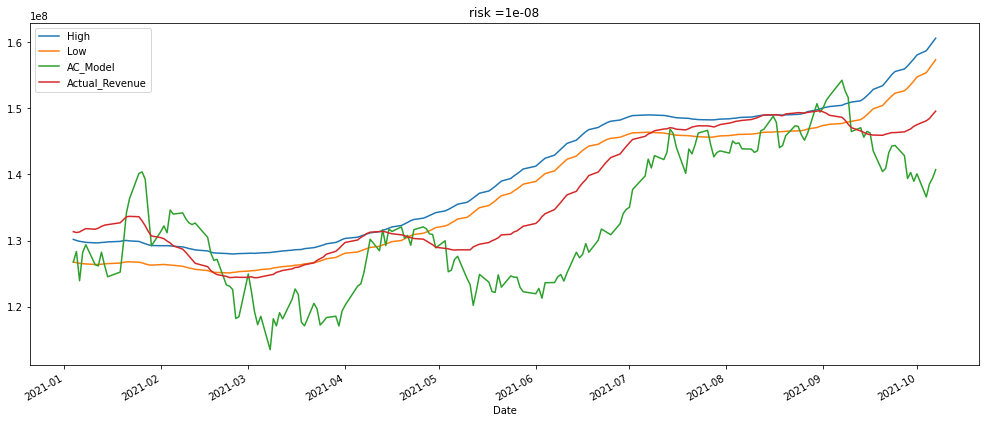

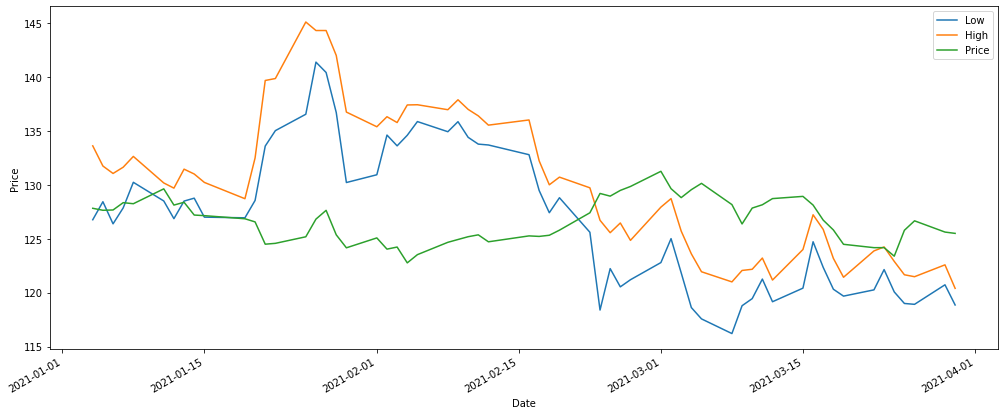

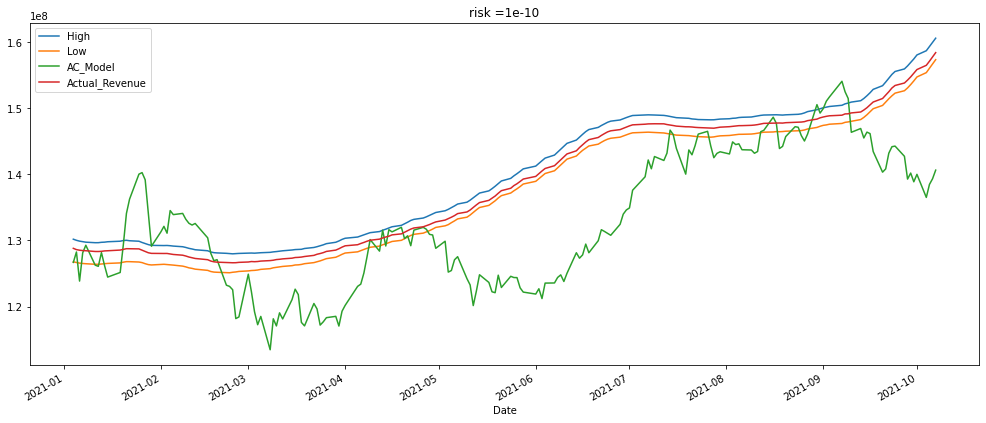

In [7]:
import pandas as pd
import FinanceDataReader as fdr
import copy
import syntheticChrissAlmgren as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta



def round_num_shares(total_shares, num_trades):
    num_shares = total_shares // num_trades + 1
    last_num_shares = num_shares
    if type(total_shares / num_trades) != int:
        last_num_shares = total_shares - (num_shares*(num_trades-1))
    
    return num_shares, last_num_shares

def calculate_revenue(df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
    total_cash_list = []
    date_list = []
    for window_num in range(slidingwindow_num):
        total_cash = 0
        for idx in range(NUM_TRADES):
            price = df[category][window_num:window_num+NUM_TRADES][idx]
            if idx == NUM_TRADES:
                daily_cash = price * last_num_shares
            else:
                daily_cash = price * num_shares
            total_cash += daily_cash
        total_cash_list.append(int(total_cash))
        date_list.append(df[category].index[window_num])
    
    return total_cash_list, date_list



df = yf.download("AAPL", start = "2020-01-01", end = "2022-01-01")
df_trad = df.tail(252)
#print(df_trad)
category = ["High", "Low"]


TOTAL_SHARES = 1000000
NUM_TRADES = 60
LIQUIDATION_TIME = 60
num_shares, last_num_shares = round_num_shares(TOTAL_SHARES, NUM_TRADES)
TRAD_DAYS = 252
slidingwindow_num = TRAD_DAYS - NUM_TRADES + 1


total_cash_list, date_list = calculate_revenue(df_trad, 'High', slidingwindow_num, NUM_TRADES, num_shares, last_num_shares)
frame1 = pd.DataFrame({"Date": date_list, "High": total_cash_list})

total_cash_list, date_list = calculate_revenue(df_trad, 'Low', slidingwindow_num, NUM_TRADES, num_shares, last_num_shares)
frame2 = pd.DataFrame({"Date": date_list, "Low":total_cash_list})

subtract_days = timedelta(60)

randomseed = 0
ANNUAL_VOLAT = 0.12                                # Annual volatility in stock price
BID_ASK_SP = 1 / 8                                 # Bid-ask spread
DAILY_TRADE_VOL = 5e6                              # Daily trading volume  
DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(TRAD_DAYS)



data_origin =yf.download("AAPL", start='2021-01-04', end='2022-01-01')
index_list = data_origin.index[:]



llambda_list= [1e-08,1e-10]
plt.rcParams['figure.figsize'] = [17.0, 7.0]
for risk in llambda_list:
    llambda = risk
    cnt = 0
    start = -312
    end = -252
    ac_date_list =[]
    Actual_Revenue_List = []
    tau = 1
    capture_list = []
    
    for idx in range(slidingwindow_num):

        data = df.iloc[start:end+1]

        if end+NUM_TRADES != 0:
            data_real_price = data_origin.iloc[end:end+NUM_TRADES]['Open'].to_numpy()
            #print(data_origin.iloc[end:end+NUM_TRADES]['Close'])
        else:
            data_real_price = data_origin.iloc[end:]['Open'].to_numpy()

        today = df.index[end]
        ac_date_list.append(today)
        
        average_daily_volume = np.mean(data['Volume'])
        average_daily_spread = np.mean(data['High'] - data['Low'])

        sigma = np.std(data['Close'])
        epsilon = average_daily_spread/2
        eta = average_daily_spread/(0.01*average_daily_volume)
        gamma = average_daily_spread/(0.1*average_daily_volume)

        env = sca.MarketEnvironment()
        env.__init__(randomSeed=0,
                     lqd_time = LIQUIDATION_TIME,
                     num_tr = NUM_TRADES,
                     lambd =llambda)

        # Initialize the Almgren-Chriss parameters so we can access them later
        env.total_shares = TOTAL_SHARES
        env.startingPrice = data.tail(n=1)['Close'][0]

        env.epsilon = epsilon
        env.singleStepVariance = (DAILY_VOLAT  * env.startingPrice) ** 2
        env.eta = eta
        env.gamma = gamma

        # Calculate some Almgren-Chriss parameters
        env.tau = tau
        env.eta_hat = env.eta - (0.5 * env.gamma * env.tau)
        env.kappa_hat = np.sqrt((env.llambda * env.singleStepVariance) / env.eta_hat)
        env.kappa = np.arccosh((((env.kappa_hat ** 2) * (env.tau ** 2)) / 2) + 1) / env.tau

        # Set the variables for the initial state
        env.shares_remaining = env.total_shares
        env.timeHorizon = env.num_n

        # Set the initial impacted price to the starting price
        env.prevImpactedPrice = env.startingPrice

        # Set the initial transaction state to False
        env.transacting = False

        # Set a variable to keep trak of the trade number
        env.k = 0

        # Get the trading list from the environment
        trl = env.get_trade_list()

        # Since we are not selling fractional shares we round up the shares in the trading list
        trade_list = utils.round_trade_list(trl)

        # set the environment to make transactions
        env.start_transactions()
        # Create an array to hold the impacted stock price
        price_hist = np.array([])

        # Implement the trading list in our similation environment
        for trade in trade_list:

            # Convert the number of shares to sell in each trade into an action
            action = trade / env.shares_remaining

            # Take a step in the environment my selling the number of shares in the current trade
            _, _, _, info = env.step(action)

            # Get the impacted price from the environment
            price_hist = np.append(price_hist, info.exec_price)

            # If all shares have been sold, stop making transactions and get the implementation sortfall
            if info.done:
                #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                break


        #new_trade_list = trade_list.astype(int)
        final_trade_list = np.trim_zeros(trade_list.astype(int))
        #print(final_trade_list)
        
#         print(today)
#         print("trade_list is",sum(trade_list))
#         print("final trade list is",len(final_trade_list))
#         #print(price_hist)
        
#         print("current risk", risk)
        capture = int(np.sum(final_trade_list * price_hist))
        capture_list.append(capture)
        
        if len(final_trade_list) != len(data_real_price):
            length = len(final_trade_list)
            modified_data_real_price = data_real_price[:length]
        else:
            modified_data_real_price = data_real_price
            
#         print("real price length", len(data_real_price))
#         print("modified real price",len(modified_data_real_price))

        #Actual_Revenue = final_trade_list*modified_data_real_price
        Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
        Actual_Revenue_List.append(Actual_Revenue_append)
        
        #sys.exit()

        start += 1
        end += 1

        if llambda == 1e-10 and idx == 0:
            price_list_num = len(price_hist)
            GBM_price_frame = pd.DataFrame({"Date":index_list[:price_list_num], "Price": price_hist})
            GBM_price_frame.set_index("Date", inplace = True)
            REAL_LOW_price_frame = data_origin['Low'].head(price_list_num)
            REAL_HIGH_price_frame = data_origin['High'].head(price_list_num)
            realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
            finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
            
            finalFrame.plot(ylabel = "Price")



    ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
    ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
    newframe = pd.merge(frame1, frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(ARframe, on='Date')
    newframe.set_index("Date", inplace=True)

    plt.rcParams['figure.figsize'] = [17.0, 7.0]
    titleName = "risk =" + str(llambda)
    newframe.plot(title = titleName)
    #print(newframe)
    


In [183]:
import pandas as pd
import FinanceDataReader as fdr
import copy
import syntheticChrissAlmgren as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta


llambda_list= [1e-04, 1e-06, 1e-08 ,1e-10]
data_origin =yf.download("AAPL", start='2020-01-02', end='2021-01-01')
data_origin


[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02   74.059998   75.150002   73.797501   75.087502   73.785919   
2020-01-03   74.287498   75.144997   74.125000   74.357498   73.068565   
2020-01-06   73.447502   74.989998   73.187500   74.949997   73.650787   
2020-01-07   74.959999   75.224998   74.370003   74.597504   73.304413   
2020-01-08   74.290001   76.110001   74.290001   75.797501   74.483597   
...                ...         ...         ...         ...         ...   
2020-12-24  131.320007  133.460007  131.100006  131.970001  130.802338   
2020-12-28  133.990005  137.339996  133.509995  136.690002  135.480576   
2020-12-29  138.050003  138.789993  134.339996  134.869995  133.676666   
2020-12-30  135.580002  135.990005  133.399994  133.720001  132.536850   
2020-12-31  134.080002  134.740005  131.720001  132.690002  131.515961   

               Volume  
Date                   
2020-01-02  135480400  
2020-01-03  146322800  
2020-01-06  118387200  
2020-01-07  108872000  
2020-01-08  132079200  
...               ...  
2020-12-24   54930100  
2020-12-28  124486200  
2020-12-29  121047300  
2020-12-30   96452100  
2020-12-31   99116600  

[253 rows x 6 columns]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\14ZD\Desktop\2022_여름학기_랩인턴\Lesson 7 -  9. Almgren and Chriss Model\syntheticChrissAlmgren.py:288: RuntimeWarning: overflow encountered in sinh
  nft = np.tanh(0.5 * self.kappa * self.tau) * (self.tau * np.sinh(2 * self.kappa * self.liquidation_time) \
C:\Users\14ZD\Desktop\2022_여름학기_랩인턴\Lesson 7 -  9. Almgren and Chriss Model\syntheticChrissAlmgren.py:290: RuntimeWarning: overflow encountered in double_scalars
  dft = 2 * (self.tau ** 2) * (np.sinh(self.kappa * self.liquidation_time) ** 2)
C:\Users\14ZD\Desktop\2022_여름학기_랩인턴\Lesson 7 -  9. Almgren and Chriss Model\syntheticChrissAlmgren.py:291: RuntimeWarning: invalid value encountered in double_scalars
  fot = nft / dft
C:\Users\14ZD\Desktop\2022_여름학기_랩인턴\Lesson 7 -  9. Almgren and Chriss Model\syntheticChrissAlmgren.py:298: RuntimeWarning: overflow encountered in double_scalars
  nst  = self.tau * np.sinh(self.kappa * self.liquidation_time) * np.cosh(self.kappa * (self.liquidation_time - self.tau)) \
C:\Users\14ZD\Desktop\20

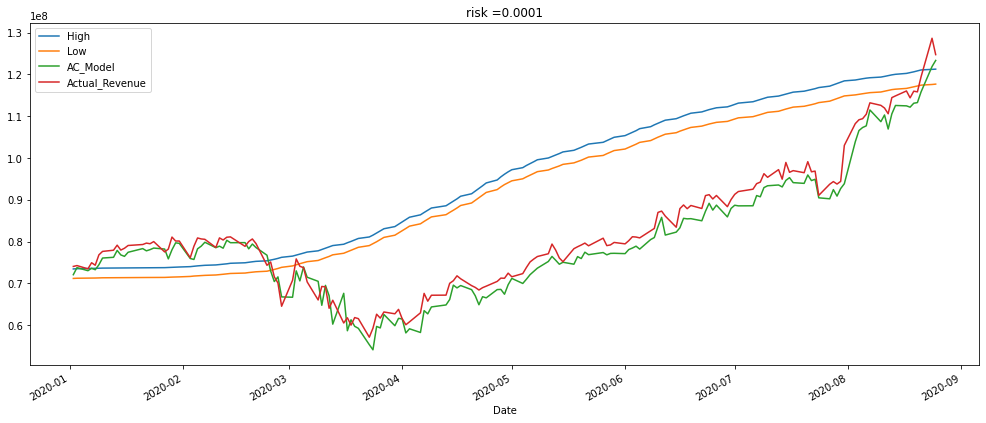

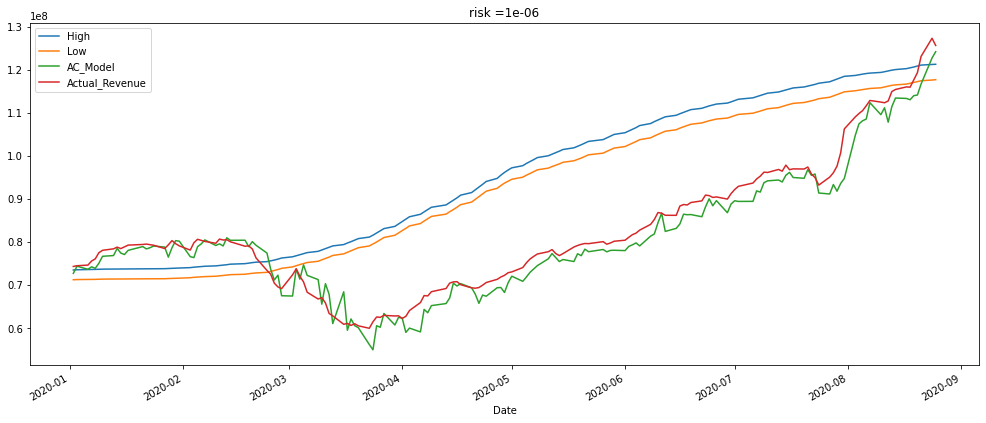

In [27]:
import pandas as pd
import FinanceDataReader as fdr
import copy
import syntheticChrissAlmgren as sca
import utils
import numpy as np
import yfinance as yf
import time
import sys
import matplotlib.pyplot as plt
from datetime import date, timedelta



def round_num_shares(total_shares, num_trades):
    num_shares = total_shares // num_trades + 1
    last_num_shares = num_shares
    if type(total_shares / num_trades) != int:
        last_num_shares = total_shares - (num_shares*(num_trades-1))
    
    return num_shares, last_num_shares

def calculate_revenue(df, category, slidingwindow_num, NUM_TRADES, num_shares, last_num_shares):
    total_cash_list = []
    date_list = []
    for window_num in range(slidingwindow_num):
        total_cash = 0
        for idx in range(NUM_TRADES):
            price = df[category][window_num:window_num+NUM_TRADES][idx]
            if idx == NUM_TRADES:
                daily_cash = price * last_num_shares
            else:
                daily_cash = price * num_shares
            total_cash += daily_cash
        total_cash_list.append(int(total_cash))
        date_list.append(df[category].index[window_num])
    
    return total_cash_list, date_list



df = yf.download("AAPL", start = "2019-01-01", end = "2021-01-01")
df_trad = df.tail(253)
#print(df_trad)
category = ["High", "Low"]


TOTAL_SHARES = 1000000
NUM_TRADES = 90
LIQUIDATION_TIME = 90
num_shares, last_num_shares = round_num_shares(TOTAL_SHARES, NUM_TRADES)
TRAD_DAYS = 253
slidingwindow_num = TRAD_DAYS - NUM_TRADES + 1


total_cash_list, date_list = calculate_revenue(df_trad, 'High', slidingwindow_num, NUM_TRADES, num_shares, last_num_shares)
frame1 = pd.DataFrame({"Date": date_list, "High": total_cash_list})

total_cash_list, date_list = calculate_revenue(df_trad, 'Low', slidingwindow_num, NUM_TRADES, num_shares, last_num_shares)
frame2 = pd.DataFrame({"Date": date_list, "Low":total_cash_list})

subtract_days = timedelta(60)

randomseed = 0
ANNUAL_VOLAT = 0.12                                # Annual volatility in stock price
BID_ASK_SP = 1 / 8                                 # Bid-ask spread
DAILY_TRADE_VOL = 5e6                              # Daily trading volume  
DAILY_VOLAT = ANNUAL_VOLAT / np.sqrt(TRAD_DAYS)



data_origin =yf.download("AAPL", start='2020-01-02', end='2021-01-01')
index_list = data_origin.index[:]



llambda_list= [1e-4,1e-6]
plt.rcParams['figure.figsize'] = [17.0, 7.0]
for risk in llambda_list:
    llambda = risk
    cnt = 0
    start = -343
    end = -253
    ac_date_list =[]
    Actual_Revenue_List = []
    tau = 1
    capture_list = []
    
    for idx in range(slidingwindow_num):

        data = df.iloc[start:end]

        if end+NUM_TRADES != 0:
            data_real_price = data_origin.iloc[end:end+NUM_TRADES]['Open'].to_numpy()
            #print(data_origin.iloc[end:end+NUM_TRADES]['Close'])
        else:
            #print(data_real_price = data_origin.iloc[end:]['Open'])
            data_real_price = data_origin.iloc[end:]['Open'].to_numpy()

        today = df.index[end]
        ac_date_list.append(today)
        
        average_daily_volume = np.mean(data['Volume'])
        average_daily_spread = np.mean(data['High'] - data['Low'])

        sigma = np.std(data['Close'])
        epsilon = average_daily_spread/2
        eta = average_daily_spread/(0.01*average_daily_volume)
        gamma = average_daily_spread/(0.1*average_daily_volume)

        env = sca.MarketEnvironment()
        env.__init__(randomSeed=0,
                     lqd_time = LIQUIDATION_TIME,
                     num_tr = NUM_TRADES,
                     lambd =llambda)

        # Initialize the Almgren-Chriss parameters so we can access them later
        env.total_shares = TOTAL_SHARES
        env.startingPrice = data.tail(n=1)['Close'][0]

        env.epsilon = epsilon
        env.singleStepVariance = (DAILY_VOLAT  * env.startingPrice) ** 2
        env.eta = eta
        env.gamma = gamma

        # Calculate some Almgren-Chriss parameters
        env.tau = tau
        env.eta_hat = env.eta - (0.5 * env.gamma * env.tau)
        env.kappa_hat = np.sqrt((env.llambda * env.singleStepVariance) / env.eta_hat)
        env.kappa = np.arccosh((((env.kappa_hat ** 2) * (env.tau ** 2)) / 2) + 1) / env.tau

        # Set the variables for the initial state
        env.shares_remaining = env.total_shares
        env.timeHorizon = env.num_n

        # Set the initial impacted price to the starting price
        env.prevImpactedPrice = env.startingPrice

        # Set the initial transaction state to False
        env.transacting = False

        # Set a variable to keep trak of the trade number
        env.k = 0

        # Get the trading list from the environment
        trl = env.get_trade_list()

        # Since we are not selling fractional shares we round up the shares in the trading list
        trade_list = utils.round_trade_list(trl)

        # set the environment to make transactions
        env.start_transactions()
        # Create an array to hold the impacted stock price
        price_hist = np.array([])

        # Implement the trading list in our similation environment
        for trade in trade_list:

            # Convert the number of shares to sell in each trade into an action
            action = trade / env.shares_remaining

            # Take a step in the environment my selling the number of shares in the current trade
            _, _, _, info = env.step(action)

            # Get the impacted price from the environment
            price_hist = np.append(price_hist, info.exec_price)

            # If all shares have been sold, stop making transactions and get the implementation sortfall
            if info.done:
                #print('Implementation Shortfall: ${:,.2f} \n'.format(info.implementation_shortfall))
                break


        #new_trade_list = trade_list.astype(int)
        final_trade_list = np.trim_zeros(trade_list.astype(int))
        #print(final_trade_list)
        
#         print(today)
#         print("trade_list is",sum(trade_list))
#         print("final trade list is",len(final_trade_list))
#         #print(price_hist)
        
#         print("current risk", risk)
        capture = int(np.sum(final_trade_list * price_hist))
        capture_list.append(capture)
        
        if len(final_trade_list) != len(data_real_price):
            length = len(final_trade_list)
            modified_data_real_price = data_real_price[:length]
        else:
            modified_data_real_price = data_real_price
            
#         print("real price length", len(data_real_price))
#         print("modified real price",len(modified_data_real_price))

        #Actual_Revenue = final_trade_list*modified_data_real_price
#         print(today)
#         print(data_real_price)
#         print(data_origin.iloc[end:end+NUM_TRADES]['Open'])
    
        Actual_Revenue_append = int(np.sum(final_trade_list*modified_data_real_price))
        Actual_Revenue_List.append(Actual_Revenue_append)
        
        #sys.exit()

        start += 1
        end += 1

        if llambda == 1e-10 and idx == 0:
            price_list_num = len(price_hist)
            GBM_price_frame = pd.DataFrame({"Date":index_list[:price_list_num], "Price": price_hist})
            GBM_price_frame.set_index("Date", inplace = True)
            REAL_LOW_price_frame = data_origin['Low'].head(price_list_num)
            REAL_HIGH_price_frame = data_origin['High'].head(price_list_num)
            realFrame = pd.merge(REAL_LOW_price_frame, REAL_HIGH_price_frame,left_index=True, right_index=True)
            finalFrame = pd.merge(realFrame,GBM_price_frame, left_index=True, right_index=True)
            
            finalFrame.plot(ylabel = "Price")



    ACframe = pd.DataFrame({"Date": ac_date_list, "AC_Model":capture_list})
    ARframe = pd.DataFrame({"Date": ac_date_list, "Actual_Revenue": Actual_Revenue_List})
    newframe = pd.merge(frame1, frame2, how='inner', on='Date').merge(ACframe, on = 'Date').merge(ARframe, on='Date')
    newframe.set_index("Date", inplace=True)

    plt.rcParams['figure.figsize'] = [17.0, 7.0]
    titleName = "risk =" + str(llambda)
    newframe.plot(title = titleName)
    #print(newframe)
    
